<a href="https://colab.research.google.com/github/zakariajaadi/data-science-portofolio/blob/main/mistral_7b_instruct_medical_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a healthcare chatbot using Mistral-7B-Instruct 🤗
Mistral 7B is a 7.3 billion parameter text-generation model that outperforms the 13B Llama 2 and even the 34B Llama 1 from Meta on many benchmarks.

In this notebook, we’ll use `Mistral 7B Instruct`, a fine-tuned version optimized for instruction-following tasks, to build an intelligent healthcare chatbot that provides helpful information about **health conditions**, **symptoms**, and **treatments**. Before we begin, let's explore two essential concepts:

## Chat history and Chat template

**Chat history** : Chat models are designed to continue chats. This means that you pass them a *conversation history*, and the model will continue the conversation by adding its response. Most modern chat models, including Mistral 7B, follow OpenAI’s message format—a list of messages, where each message is a dictionary containing:
* *Role* : Defines the speaker ("system", "user", or "assistant")
* *Content* : The message text


**Chat template**: Since models process text, this chat history list must be converted into a single formatted string that matches the template the model was trained on





# 1- Chatbot implementation
Instead of relying on a pre-built pipeline, I've chosen to implement manual text generation to have a fine-grained control over the text generation process. I have section below for the pipeline version


**1- install depandacies and import libraries**

In [ ]:
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install -q -U gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
import gradio as gr

**2- NF4 Quantization config**

reduce memory footprint of the model weights


In [ ]:
# NF4 Quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

**3- Load Mistral tokenizer and model**

In [ ]:
# Model checkpoint
model_checkpoint = "mistralai/Mistral-7B-Instruct-v0.3"
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# Load Model
model = AutoModelForCausalLM.from_pretrained(
        model_checkpoint,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

**4- Code for text generation with Mistral**


In [ ]:
def generate_response(chat, tokenizer, model, temperature):
    """
        Generates model response using chat history.
    """
    # Ensure inference mode
    model.eval()

    # Apply the chat template
    formatted_chat = tokenizer.apply_chat_template(chat,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

    # Tokenize the chat
    inputs = tokenizer(formatted_chat,
                      return_tensors="pt",
                      add_special_tokens=False)

    # Move the tokenized inputs and attention masks to the same device the model is on (GPU/CPU)
    inputs = {key: tensor.to(model.device) for key, tensor in inputs.items()}

    # Generate text from the model
    outputs = model.generate(**inputs,
                             max_new_tokens=512,
                             do_sample=True,
                             temperature=temperature,
                             pad_token_id=tokenizer.eos_token_id
                             )

    # Decode the output back to a string
    decoded_output = tokenizer.decode(outputs[0][inputs['input_ids'].size(1):],
                                      skip_special_tokens=True)
    return decoded_output

**5- Chatbot code & UI Using gradio**

In [ ]:
def chat_interface(message, history):
    """ Gradio function."""
    # Initialize history with system prompt
    if not history:
        history.append({"role": "system", "content": system_prompt})

    # Prepare chat concatenating history and user input
    chat = history + [{"role": "user", "content": message}]

    # Generate response
    response = generate_response(chat,tokenizer,model, temperature=0.1)

    return response


# Define chatbot interface
chatbot=gr.ChatInterface(fn=chat_interface,
                 type="messages",
                 title="Medical Assistant Chatbot",
                 description=" Ask me anything related to health conditions, symptoms, and treatments.",
                 examples=["What are the symptoms of COVID?",
                          "How can I lower my blood pressure?",
                          "What is the treatment for a common cold?"])

**6- Run the chatbot**

In [ ]:
system_prompt="""You are a medical assistant chatbot designed to provide accurate and helpful information
                 about health conditions, symptoms, and treatments.Your responses should be clear, concise,
                 and based on widely accepted medical knowledge. If you are unsure about an answer, say
                 'I am not a doctor, but you should consult a healthcare professional for this issue'."""

In [ ]:
chatbot.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1078354e406e466a8e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**7- Demo** 🚀

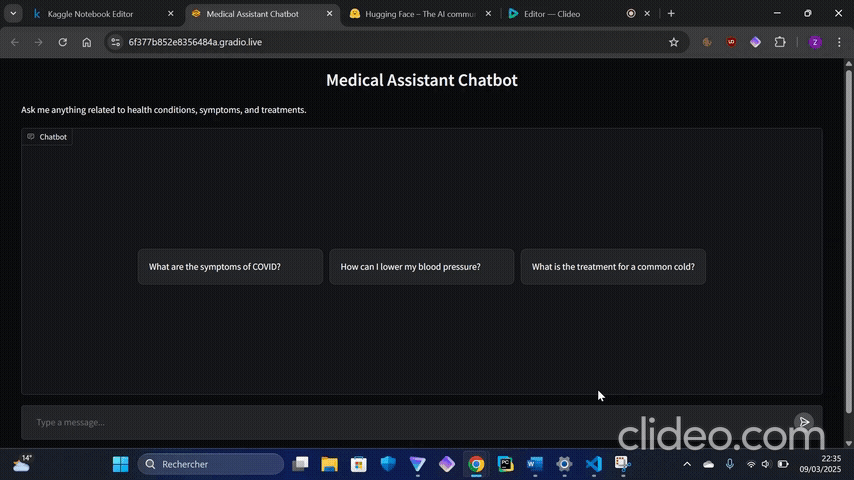

In [ ]:
# @title
from IPython.display import Image
gif_filename = 'mistral_chatbot_demo.gif'
Image(filename=gif_filename)

# 2- Bonus : Chatbot implementation (pipeline version)


**1- Create the pipeline**



In [ ]:
# Pipeline
pipe = pipeline("text-generation",
                 model=model,
                 tokenizer = tokenizer,
                 torch_dtype=torch.bfloat16,
                 device_map="auto",
                 pad_token_id=tokenizer.eos_token_id)

Device set to use cuda:0


**2- text generation code using mistral**

In [ ]:
def generate_response_pipeline(chat, pipe, temperature):
  """
      Generates model response using chat history (with pipeline).
  """

  # Generate text from the model
  sequences = pipe(chat,
                  max_new_tokens=512,
                  do_sample=True,
                  temperature= temperature,
                  num_return_sequences=1)


  # Get generated text
  output = sequences[0]['generated_text']

  # Get assistant message content
  response = output[-1]["content"]

  return response

**3- Chatbot code and UI using Gradio**

In [ ]:
def chat_interface(message, history):
    """ Gradio function."""
    # Initialize history with system prompt
    if not history:
        history.append({"role": "system", "content": system_prompt})

    # Prepare chat concatenating history and user input
    chat = history + [{"role": "user", "content": message}]

    # Generate response
    response = generate_response_pipeline(chat,pipe, temperature=0.1)

    return response


# Create Gradio interface
chatbot=gr.ChatInterface(fn=chat_interface,
                 type="messages",
                 title="Medical Assistant Chatbot",
                 description=" Ask me anything related to health conditions, symptoms, and treatments.",
                 examples=["What are the symptoms of COVID?",
                          "How can I lower my blood pressure?",
                          "What is the treatment for a common cold?"])

**4- Run the chatbot**

In [ ]:
system_prompt="""You are a medical assistant chatbot designed to provide accurate and helpful information about health conditions,
                 symptoms, and treatments. Your responses should be clear, concise,and based on widely accepted medical knowledge.
                 If you are unsure about an answer, say 'I am not a doctor, but you should consult a healthcare professional for
                 this issue'."""

In [ ]:

chatbot.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://54c59c55e96d3802e8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Et voila ! 🎉 🤗